In [3]:
# 1. Imports & Data Load
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

df = pd.read_csv('ds_salaries.csv')
print(df.shape, df.isna().sum())


(3755, 11) work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


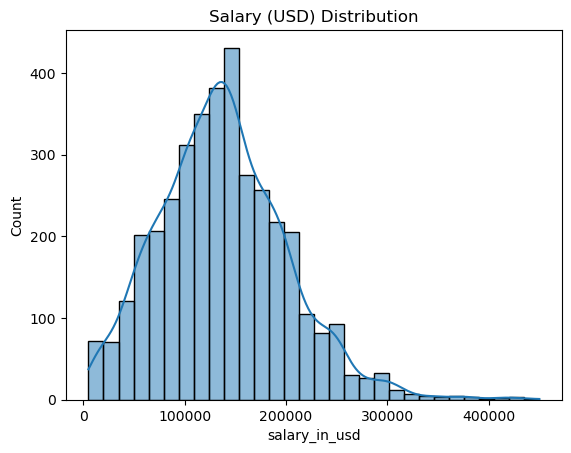

remote_ratio
0      1923
100    1643
50      189
Name: count, dtype: int64
experience_level
SE    2516
MI     805
EN     320
EX     114
Name: count, dtype: int64


In [4]:
# 2. Quick EDA
sns.histplot(df['salary_in_usd'], bins=30, kde=True)
plt.title("Salary (USD) Distribution")
plt.show()

print(df['remote_ratio'].value_counts())
print(df['experience_level'].value_counts())


In [5]:
# 3. Preprocessing
df = df.drop(columns=['salary', 'salary_currency'])
df['experience_level'] = df['experience_level'].map({'EN':'Entry','MI':'Mid','SE':'Senior','EX':'Executive'})
df['remote_ratio'] = df['remote_ratio'].astype(int)


In [6]:
# Label encode ordinal columns
le_exp = LabelEncoder()
le_company = LabelEncoder()
df['experience_level'] = le_exp.fit_transform(df['experience_level'])
df['company_size'] = le_company.fit_transform(df['company_size'].astype(str))


In [7]:
# One-hot for categorical
df = pd.get_dummies(df, columns=['employment_type', 'job_title', 'employee_residence', 'company_location'], drop_first=True)


In [8]:
# Train/test split
X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
import pickle

# Suppose these are your features after preprocessing
feature_columns = X_train.columns.tolist()

# Save feature columns
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)


In [9]:
# 4. Train & Evaluate Models
models = {
    'Linear': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(tree_method='hist', verbosity=0, random_state=42)
}

scores = {}
for name, m in models.items():
    m.fit(X_train, y_train)
    pred = m.predict(X_test)
    scores[name] = {
        'RMSE': mean_squared_error(y_test, pred, squared=False),
        'R2': r2_score(y_test, pred)
    }

pd.DataFrame(scores).T


C:\Users\pxlaw\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\pxlaw\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\pxlaw\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,RMSE,R2
Linear,5.897475e+12,-8.810047e+15
RandomForest,4.872005e+04,3.987413e-01
XGBoost,4.912177e+04,3.887850e-01


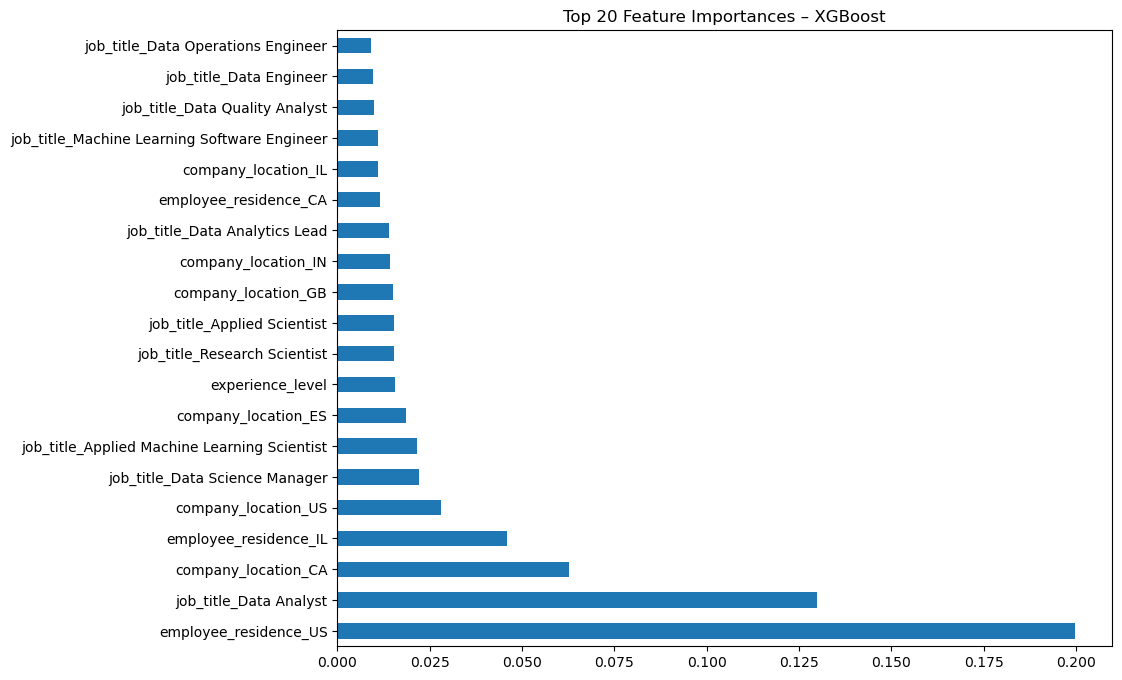

In [10]:
# 5. Feature Importance (for best model, say XGBoost)
best = models['XGBoost']
imp = pd.Series(best.feature_importances_, index=X.columns).nlargest(20)
imp.plot(kind='barh', figsize=(10, 8))
plt.title("Top 20 Feature Importances – XGBoost")
plt.show()


In [11]:
# 6. Save Model + Encoders
import joblib
joblib.dump(best, 'best_model.pkl')
joblib.dump(le_exp, 'le_exp.pkl')
joblib.dump(le_company, 'le_company.pkl')


['le_company.pkl']

In [21]:
%%writefile app.py
import streamlit as st, pandas as pd, joblib, numpy as np

df_orig = pd.read_csv('ds_salaries.csv')

st.title("💵 Data Science Salary Predictor")

# Load
model = joblib.load('best_model.pkl')
le_exp = joblib.load('le_exp.pkl')
le_company = joblib.load('le_company.pkl')
X_columns = joblib.load('feature_columns.pkl')  # Saved list of processed features

# User input
exp = st.selectbox("Experience Level", ['Entry','Mid','Senior','Executive'])
remote = st.selectbox("Remote Ratio", [0, 50, 100])
company_size = st.selectbox("Company Size", ['S', 'M', 'L'])
emp_type = st.selectbox("Employment Type", sorted(df_orig['employment_type'].unique()))
job_title = st.selectbox("Job Title", sorted(df_orig['job_title'].unique()))
residence = st.selectbox("Employee Residence", sorted(df_orig['employee_residence'].unique()))
comp_loc = st.selectbox("Company Location", sorted(df_orig['company_location'].unique()))

# Input frame
inp = {
    'experience_level': le_exp.transform([exp])[0],
    'remote_ratio': remote,
    'company_size': le_company.transform([company_size])[0],
}
# Add one-hot features
for cat in ['employment_type_'+emp_type, 'job_title_'+job_title,
            'employee_residence_'+residence, 'company_location_'+comp_loc]:
    inp[cat] = 1

X_inp = pd.DataFrame([inp]).reindex(columns=X_columns, fill_value=0)

# Predict
if st.button("Predict"):
    sal = model.predict(X_inp)[0]
    st.success(f"Estimated Salary: ${sal:,.2f} USD")


Overwriting app.py


In [ ]:
!streamlit run app.py